In [3]:
import os
import tarfile
import urllib.request
import pandas as pd


REMOTE_DATA_URL='https://raw.githubusercontent.com/ageron/handson-ml/master/datasets/housing/housing.tgz'
SAVE_PATH='data'

def fetch_data(save_path, remote_url):
    if not os.path.isdir(save_path):
        os.makedirs(save_path)
    r = urllib.request.urlopen(remote_url)
    t = tarfile.open(fileobj=r, mode='r:gz')
    t.extractall(save_path)
    return os.path.join(os.getcwd(), save_path, 'housing.csv')

def load_data(path_to_data_file):
    return pd.read_csv(path_to_data_file)

In [4]:
data_file = fetch_data(SAVE_PATH, REMOTE_DATA_URL)
housing_info = load_data(data_file)
housing_info.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [5]:
housing_info.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [6]:
housing_info['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [7]:
housing_info.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


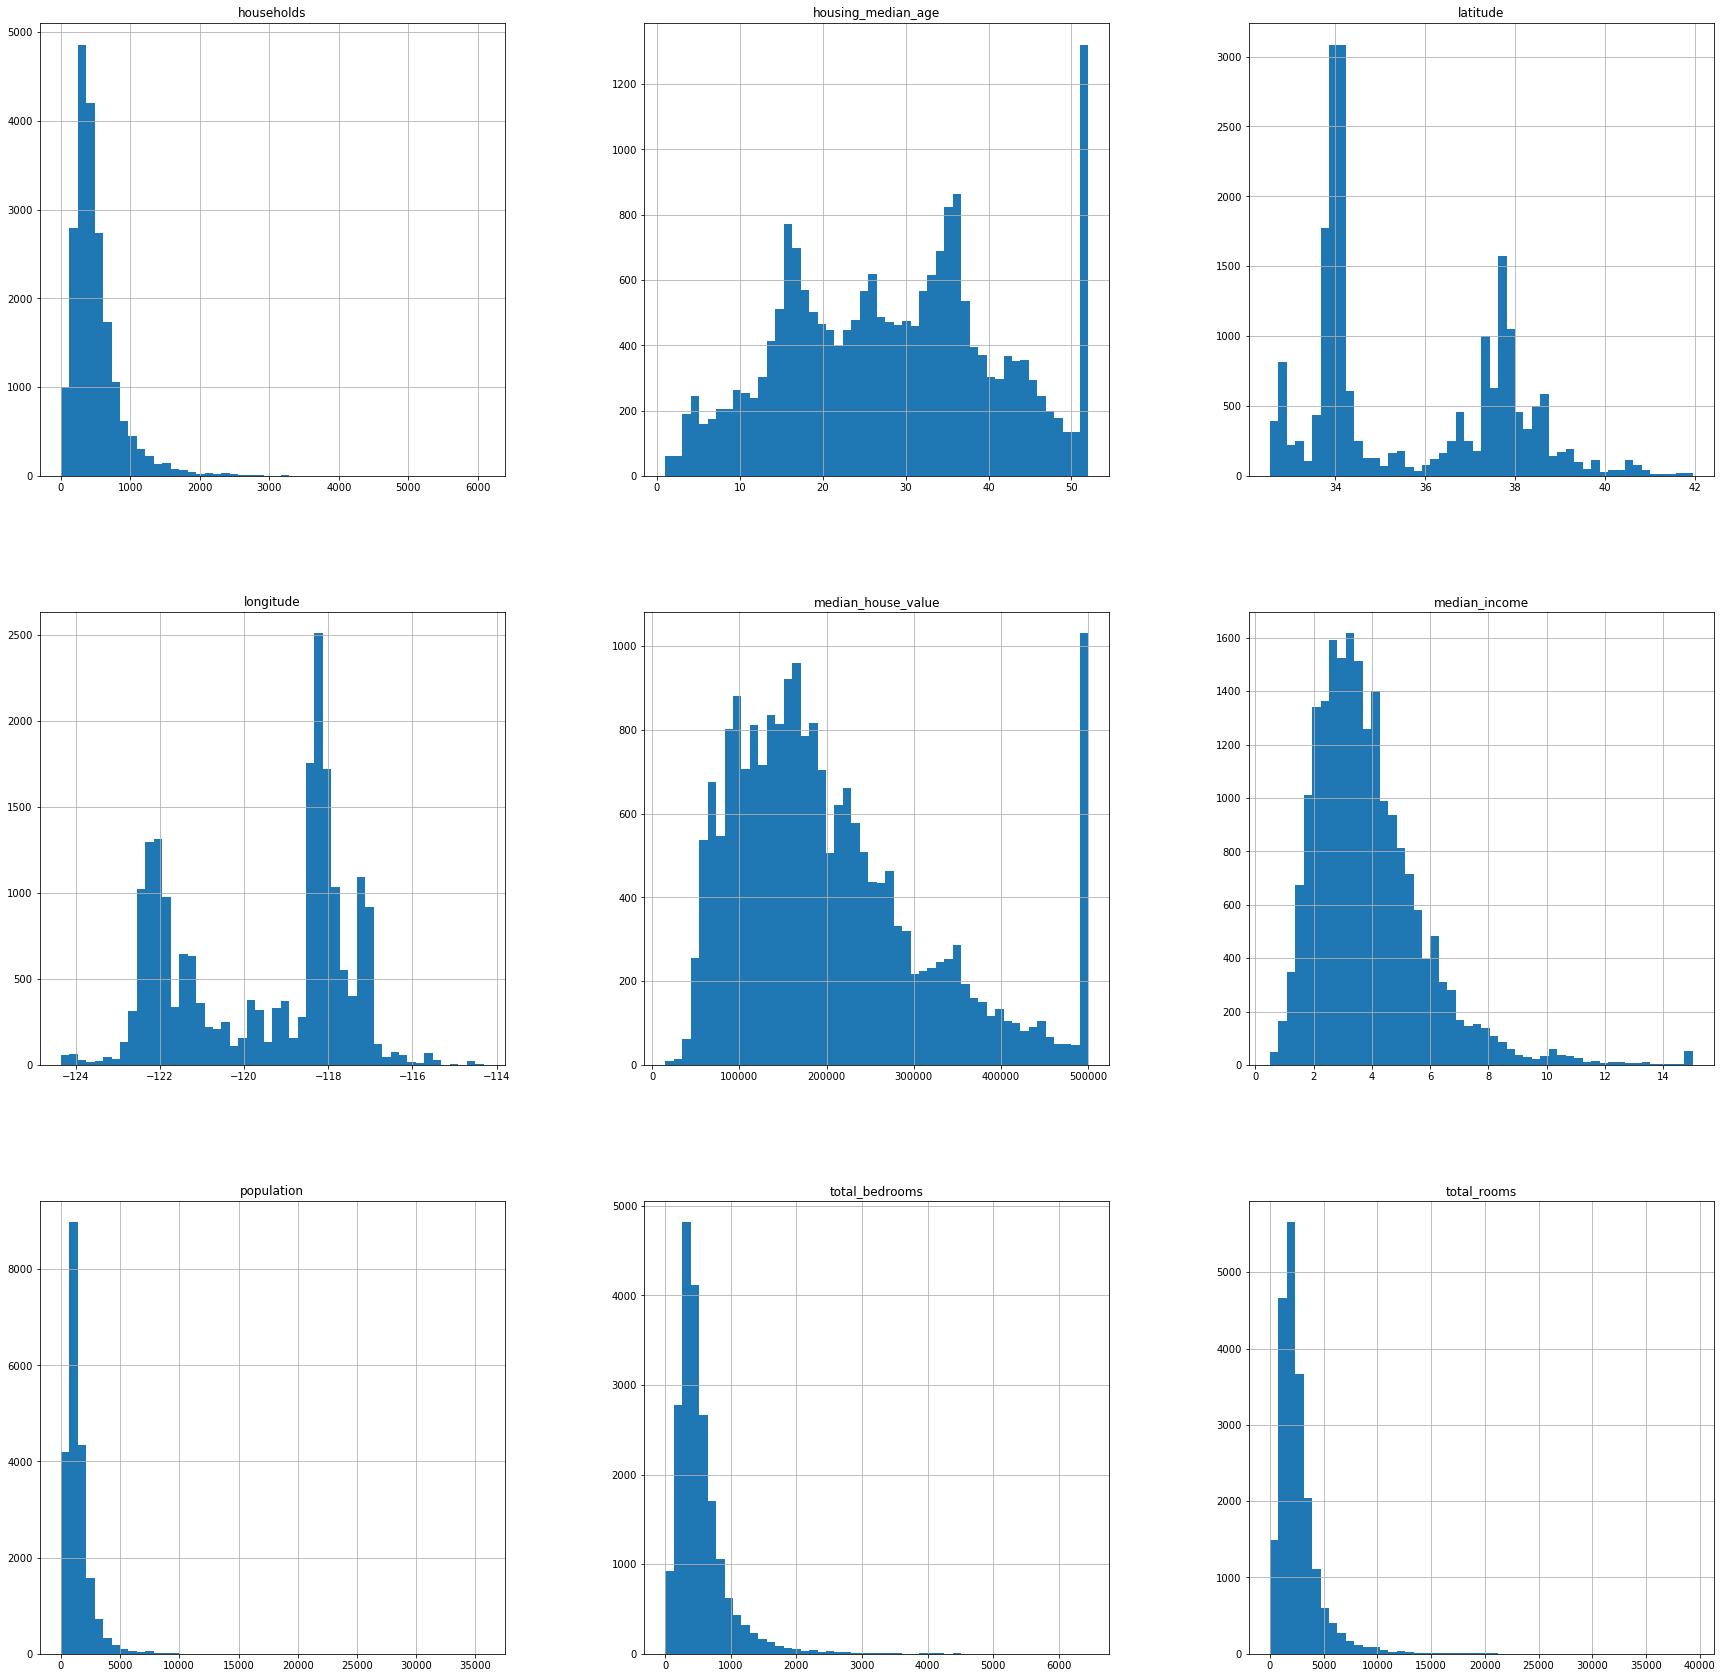

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
housing_info.hist(bins=50, figsize=(30,30))


plt.show()

In [9]:
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit

#Make median income easier to analyze, by creating discrete categories
housing_info['income_cat'] = np.ceil(housing_info['median_income'] / 1.5)
housing_info['income_cat'].where(housing_info['income_cat'] < 5, 5.0, inplace=True)

#Create stratified test, train set. This is fundamental because we do not want skewed data in our sets.
#
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=5)
for train_i, test_i in split.split(housing_info, housing_info['income_cat']):
    strait_train_set = housing_info.loc[train_i]
    strait_test_set = housing_info.loc[test_i]

#Now get rid of our helper category used for stratification.
for s in (strait_train_set, strait_test_set):
    s.drop(['income_cat'], axis=1, inplace=True)


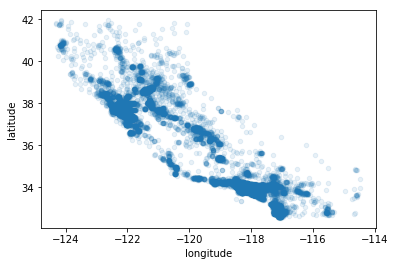

In [10]:
#Let's look at the data more in-depth, by aliasing the training data and forgetting about the test data set
hd = strait_train_set.copy()
hd.plot(kind='scatter', x='longitude', y='latitude', alpha=0.1)

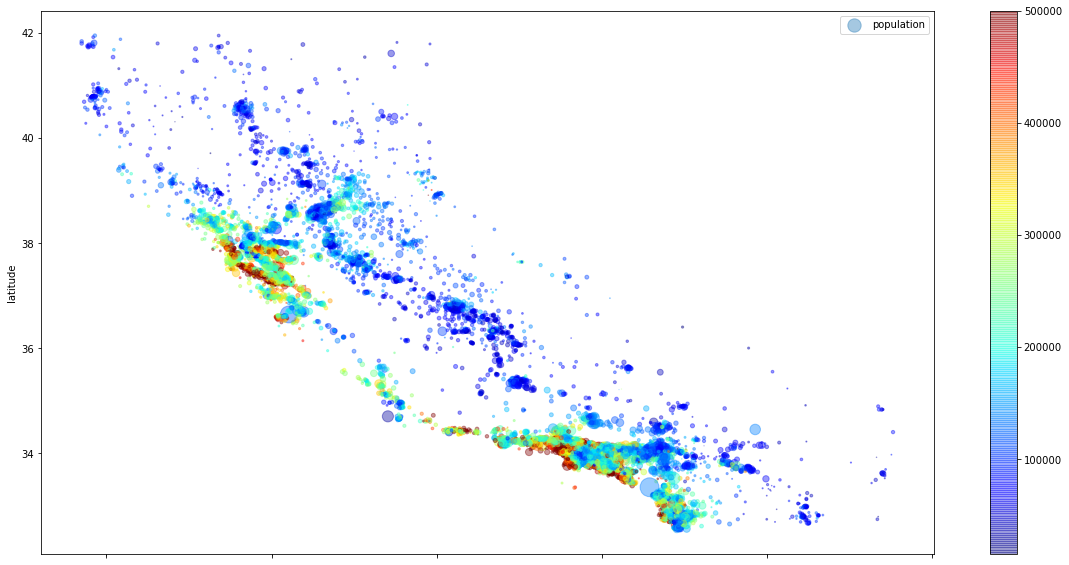

In [11]:
#Let's tweak the color to understand the data
hd.plot(kind='scatter', x='longitude', y='latitude', alpha=0.4, s=hd['population']/100, 
        label='population', c=hd["median_house_value"], cmap=plt.get_cmap('jet'), colorbar=True, figsize=(20,10))
plt.legend()


In [15]:
#Find correlations between different parts of the data
corr_matrix = hd.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.686517
total_rooms           0.135338
housing_median_age    0.104154
households            0.066256
total_bedrooms        0.051036
population           -0.023767
longitude            -0.047873
latitude             -0.142519
Name: median_house_value, dtype: float64

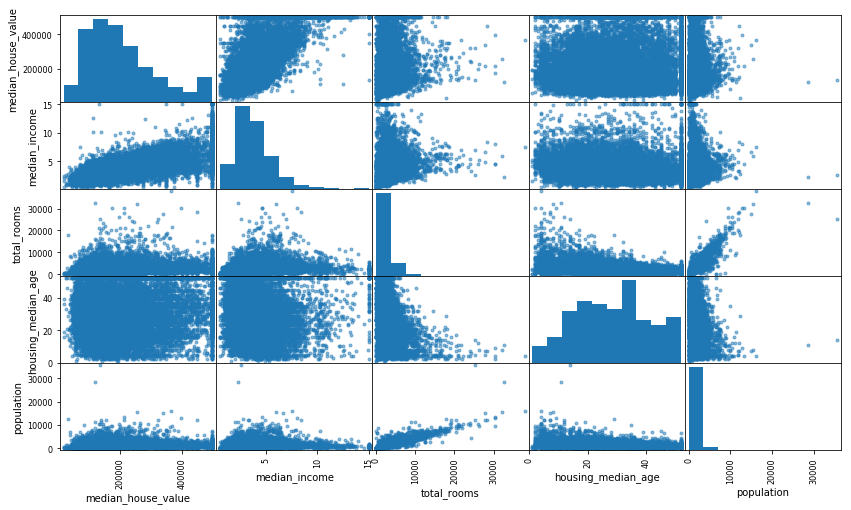

In [18]:
#The strongest correlation is in found with median_income
from pandas.tools.plotting import scatter_matrix

attributes = ['median_house_value', 'median_income', 'total_rooms', 'housing_median_age', 'population']
scatter_mat = scatter_matrix(hd[attributes], figsize=(14,8))


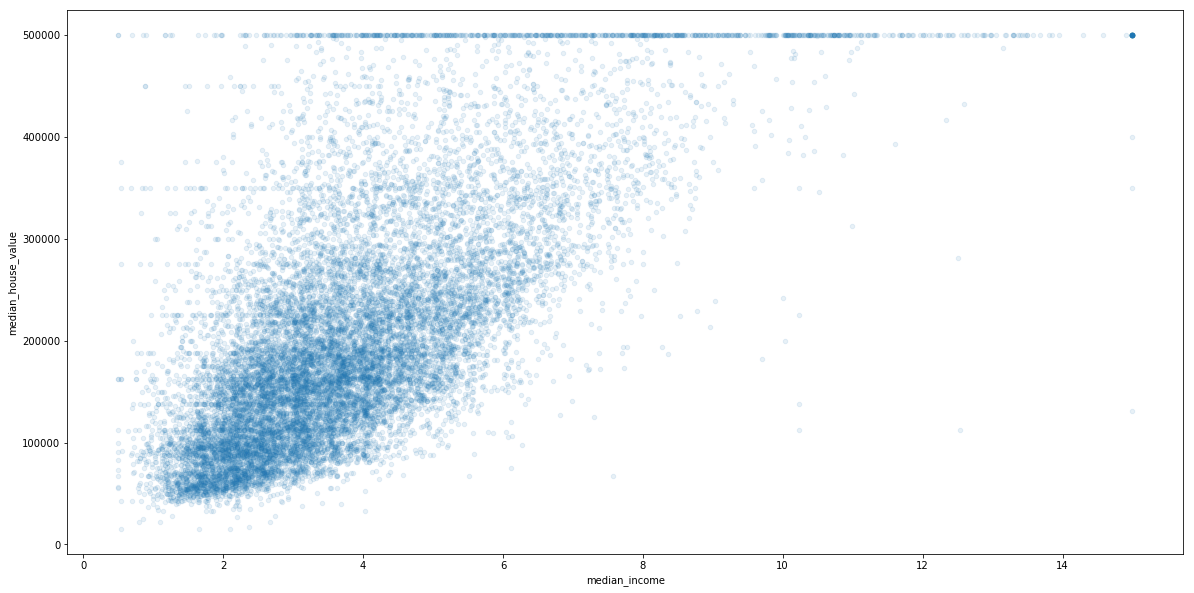

In [20]:
hd.plot(kind='scatter', x='median_income', y='median_house_value', alpha=0.1, figsize=(20,10))

In [42]:
#Next step is to start transformation in the data to clean it up and prepare it for machine learning algorithms
#eg.
hd['pop_in_household'] = hd['population']/hd['households']

#However there is a quicker, better way to reuse scikit api to create a pipeline of transformations
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import Imputer, StandardScaler, LabelBinarizer

rooms_ix, bed_ix, pop_ix, household_ix = 3, 4, 5, 6
class CombinedAttr(BaseEstimator, TransformerMixin):
    
    
    def __init__(self, add_bed_per_room=True):
        self.add_beds = add_bed_per_room

    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        rooms_per_household = X[:,rooms_ix] / X[:, household_ix]
        pop_per_household = X[:,pop_ix] / X[:, household_ix]
        if self.add_beds:
            beds_per_room = X[:, bed_ix]/X[:, rooms_ix]
            return np.c_[X, rooms_per_household, pop_per_household, beds_per_room]
        else:
            return np.c_[X, rooms_per_household, pop_per_household]
        
#Simple class to remove columns 
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attributes_names_to_keep):
        self.attribute_names = attributes_names_to_keep
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[self.attribute_names].values
    
        


 

In [46]:
#Now that we have a custom transformer let's create a pipeline of transformations to automate data cleaning
#First let's get a handle on numerical a non-numerical attributes since they deserve different transformations
numerical_attrs = list(hd.drop('ocean_proximity', axis=1))
category_attrs = ['ocean_proximity']

#Create a pipeline of transformations for numerical data only
numerical_pipeline = Pipeline([
    ('selector', DataFrameSelector(numerical_attrs)), #select the proper columns
    ('imputer', Imputer(strategy="median")), #Fill the missing data with the median
    ('attr_calc', CombinedAttr()), #Add calculated fields as shown above
    ('std_scaler', StandardScaler()) #Scale all the numbers so they are comparable
])


category_pipeline = Pipeline([
    ('selector', DataFrameSelector(category_attrs)), #select the cat props
    ('binarizer', LabelBinarizer()) #Binarize the categories to a sparse matrix
])

#Combine the pipelines
the_pipeline = FeatureUnion(transformer_list=[
    ('num_xform', numerical_pipeline),
    ('cat_xform', category_pipeline),
])

hd_prepared = the_pipeline.fit_transform(hd)
hd_prepared




array([[ 1.18833929, -1.30610549,  0.10823333, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.69921865, -0.72149457,  0.3456861 , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.8389674 , -0.81035543, -0.44582314, ...,  0.        ,
         0.        ,  0.        ],
       ..., 
       [-1.54674352,  1.2194137 ,  0.0290824 , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.76909302, -0.80100166,  0.10823333, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.72916481, -0.84309364,  0.58313887, ...,  0.        ,
         0.        ,  0.        ]])